# ISSS609 Text Analytics & Applications Group Project

# 1. Set up environment

In [2]:
pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer  # VADER sentiment analyser
from afinn import Afinn # AFINN sentiment analyser
from transformers import AutoTokenizer, AutoModelForSequenceClassification # BERTweet sentiment analyser
from transformers import pipeline
from wordcloud import WordCloud
from collections import Counter
from itertools import chain

C:\Users\shaof\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Data processing

## 2.1 Import tweet data

In [3]:
isis = pd.read_csv('./data/tweets.csv')
print(isis.head())
print()
print(isis.describe())

            name         username  \
0  GunsandCoffee  GunsandCoffee70   
1  GunsandCoffee  GunsandCoffee70   
2  GunsandCoffee  GunsandCoffee70   
3  GunsandCoffee  GunsandCoffee70   
4  GunsandCoffee  GunsandCoffee70   

                                    description location  followers  \
0  ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews      NaN        640   
1  ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews      NaN        640   
2  ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews      NaN        640   
3  ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews      NaN        640   
4  ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews      NaN        640   

   numberstatuses            time  \
0              49  1/6/2015 21:07   
1              49  1/6/2015 21:27   
2              49  1/6/2015 21:29   
3              49  1/6/2015 21:37   
4              49  1/6/2015 21:45   

                                              tweets  
0  ENGLISH TRANSLATION: 'A MESSAGE TO THE TRUTHFU...  
1  ENGLISH TRANSL

## 2.2 Preprocess Tweet Data

In [4]:
def preprocess(tweet):
    # A number of the tweets start with ENGLISH TRANSLATIONS: so we will remove it 
    tweet = re.sub(r'ENGLISH TRANSLATION:', '', tweet)
    # Also strip the tweets of non-alphabetic characters except #
    tweet = re.sub(r'[^A-Za-z# ]', '', tweet)
    # Remove retweet indicators
    tweet = re.sub(r'^[Rr][Tt]\s@\w+: ', '', tweet)
    tweet = re.sub(r'^[Rr][Tt]\s+', '', tweet)
    # Remove X (Twitter) handles
    tweet = re.sub(r'@\w+', '', tweet) 
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)
    # Remove 'amp'
    tweet = re.sub(r'amp', '', tweet)
    
    words = tweet.strip().split()
  
    hashtags = [word for word in words if re.match(r'#', word) != None]
    words = [word.lower() for word in words if word not in hashtags]

    for hashtag in hashtags:
        hashtag = re.sub(r'#', '', hashtag)
        words_tag = []
        current_word = ''
        for a in hashtag:
            if a.isupper() and current_word != '':
                words_tag.append(current_word)
                current_word = '' + a.lower()
            else:
                current_word = current_word + a.lower()
        words_tag.append(current_word)
        words.extend(words_tag)

    # Option 1: Remove stopwords and stem words using porter stemmer
    p_stem = PorterStemmer()
    words = [p_stem.stem(word.lower()) for word in words if word not in stopwords.words('english')]

    # Option 2: Remove stopwords and lemmatize words
    #lemmatizer = WordNetLemmatizer()
    #words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stopwords.words('english')]
    
    # Remove duplicates
    words = list(set(words))

    return words

isis['wordlist'] = [preprocess(tweet) for tweet in isis['tweets']]

print(isis['wordlist'].head())
print()
print(isis['wordlist'].describe())

0    [abu, al, messag, muham, maqdisi, sheikh, trut...
1    [fatih, integr, al, easi, peopl, sheikh, jawla...
2    [fatih, al, sheikh, first, jawlani, audio, ha,...
3    [al, wuhayshi, aqap, promis, nasir, sheikh, ha...
4    [dislik, disbeliev, respons, although, stateme...
Name: wordlist, dtype: object

count     17410
unique    16558
top          []
freq        280
Name: wordlist, dtype: object


# 3. Exploratory Data Analysis

## 3.1 Calculate word count in original tweets

count    17410.000000
mean       108.507754
std         36.376835
min          1.000000
25%         84.000000
50%        124.000000
75%        140.000000
max        160.000000
Name: word_count, dtype: float64


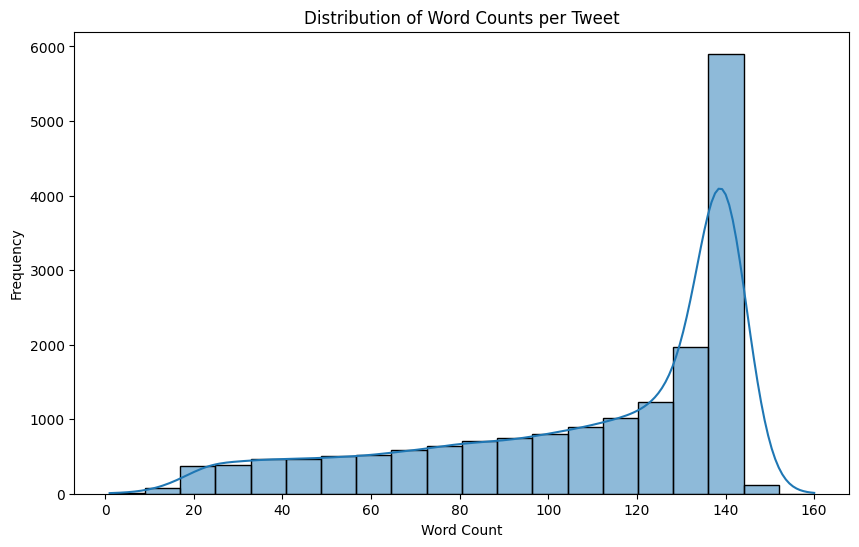

In [35]:
# Calculate word counts
isis['word_count'] = isis['tweets'].apply(lambda x: len(x))

# Display basic statistics
print(isis['word_count'].describe())

plt.figure(figsize=(10,6))
sns.histplot(isis['word_count'], bins=20, kde=True)
plt.title('Distribution of Word Counts per Tweet')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

## 3.2 Word Cloud of original tweets

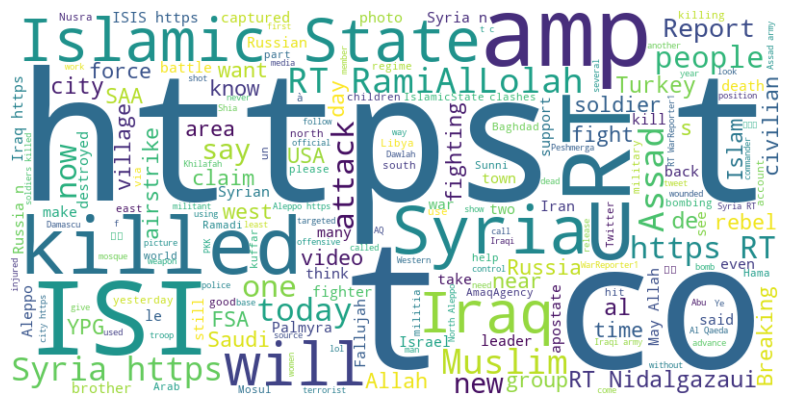

In [14]:
# Flatten the wordlist and combine all words into a single string
all_words = ' '.join(isis['tweets'])

# Create the word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 3.3 Calculate word count in processed tweets

count    17410.000000
mean         9.166284
std          4.230544
min          0.000000
25%          6.000000
50%         10.000000
75%         12.000000
max         23.000000
Name: word_count, dtype: float64


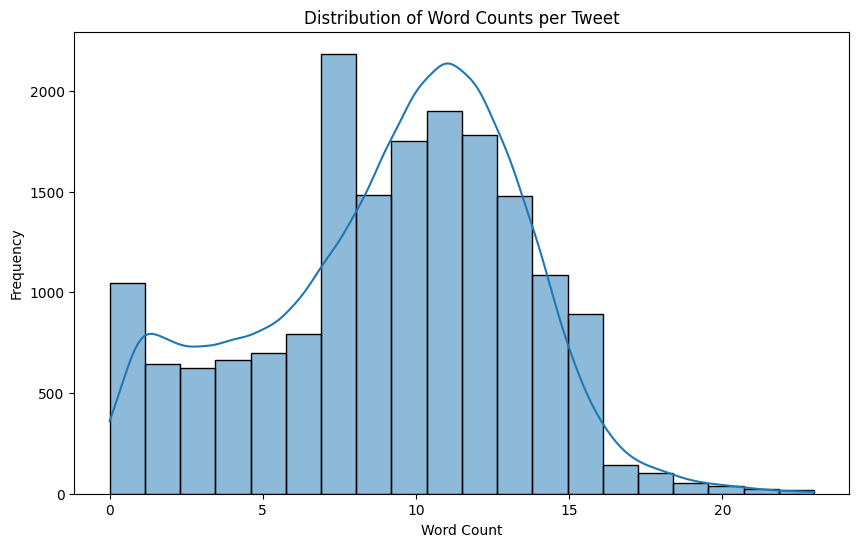

In [28]:
# Calculate word counts
isis['word_count'] = isis['wordlist'].apply(lambda x: len(x))

# Display basic statistics
print(isis['word_count'].describe())

plt.figure(figsize=(10,6))
sns.histplot(isis['word_count'], bins=20, kde=True)
plt.title('Distribution of Word Counts per Tweet')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

## 3.4 Word Cloud of processed tweets

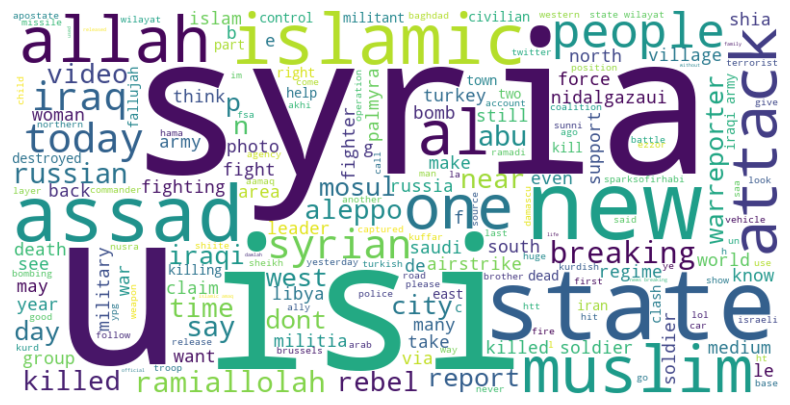

In [29]:
# Flatten the wordlist and combine all words into a single string
all_words = ' '.join(chain.from_iterable(isis['wordlist']))

# Create the word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 4. Sentiment Analysis

# 4.1 Test and compare models

3 methods of sentiment analysis, i.e. VADER, AFINN and BERTweet are tested and compared.

### 4.1.1 Perform sentiment analysis using VADER
VADER (Valence Aware Dictionary and sEntiment Reasoner) uses a lexicon of words and heuristics to determine the sentiment of a text. It assigns predefined sentiment scores to words and accounts for intensity modifiers (e.g., "very good" vs. "good").

Reference:
Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on
Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.


In [42]:
# Initialize VADER sentiment analyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment score using VADER
def sentiment_analysis_vader(tweet_words):
    # Join the preprocessed word list back into a sentence to feed into VADER
    joined_words = " ".join(tweet_words)
    scores = sia.polarity_scores(joined_words)
    return scores['compound']  # VADER returns 'compound' as the overall sentiment score

# Apply sentiment analysis to each tweet's wordlist and store the result in a new column
isis['sentiment_score'] = isis['wordlist'].apply(sentiment_analysis_vader)

# Display the dataset with sentiment scores
print(isis[['tweets', 'sentiment_score']].head())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shaof\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                              tweets  sentiment_score
0  ENGLISH TRANSLATION: 'A MESSAGE TO THE TRUTHFU...           0.3182
1  ENGLISH TRANSLATION: SHEIKH FATIH AL JAWLANI '...           0.0000
2  ENGLISH TRANSLATION: FIRST AUDIO MEETING WITH ...           0.3400
3  ENGLISH TRANSLATION: SHEIKH NASIR AL WUHAYSHI ...           0.3400
4  ENGLISH TRANSLATION: AQAP: 'RESPONSE TO SHEIKH...           0.0000


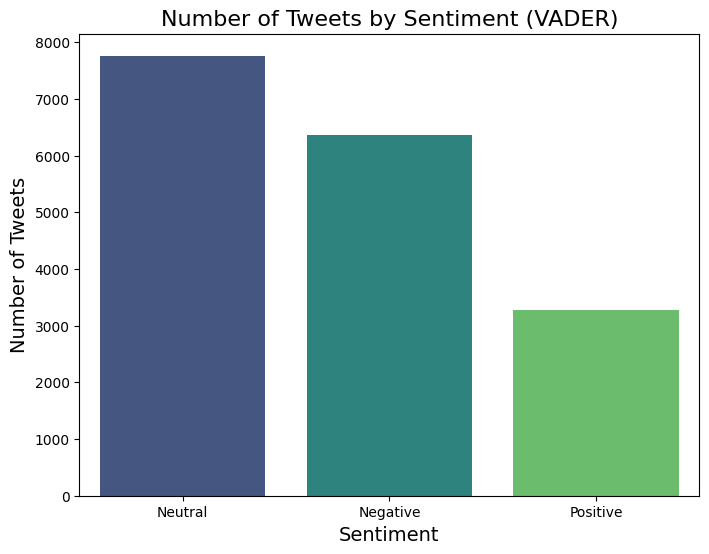

In [43]:
# Classify each tweet as positive, neutral, or negative based on sentiment score
def classify_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply classification to the sentiment scores
isis['sentiment_label'] = isis['sentiment_score'].apply(classify_sentiment)

# Count the number of tweets in each category
sentiment_counts = isis['sentiment_label'].value_counts().reset_index()

# Rename columns for clarity
sentiment_counts.columns = ['Sentiment', 'Count']

# Plot the sentiment distribution
plt.figure(figsize=(8,6))
sns.barplot(x='Sentiment', y='Count', data=sentiment_counts, hue='Sentiment', dodge=False, palette='viridis')
plt.title('Number of Tweets by Sentiment (VADER)', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Number of Tweets', fontsize=14)
plt.show()

In [48]:
# Sample positive tweet
print("** Sample positive tweet **")
print(isis['tweets'].iloc[10568])
print("Sentiment score:", isis['sentiment_score'].iloc[10568])
print("Sentiment label:", isis['sentiment_label'].iloc[10568])
print ("\n")

# Sample negative tweet
print("** Sample negative tweet **")
print(isis['tweets'].iloc[3605])
print("Sentiment score:", isis['sentiment_score'].iloc[3605])
print("Sentiment label:", isis['sentiment_label'].iloc[3605])
print ("\n")

# Sample neutral tweet
print("** Sample neutral tweet **")
print(isis['tweets'].iloc[3659])
print("Sentiment score:", isis['sentiment_score'].iloc[3659])
print("Sentiment label:", isis['sentiment_label'].iloc[3659])
print ("\n")


** Sample positive tweet **
The Islamic state smarter fighter than the all fighting around the world they r never defeated they are continues to expand it teritry
Sentiment score: 0.0772
Sentiment label: Positive


** Sample negative tweet **
#USA #Pentagon: Countries who can not join the anti #ISIS Coalition militarily should financially contribute to it..
Sentiment score: -0.0258
Sentiment label: Negative


** Sample neutral tweet **
State news in english. Audio.
https://t.co/di39j9yoNu
Wanna hear?? Okay then go there.
Sentiment score: 0.2263
Sentiment label: Positive




### 4.1.2 Perform sentiment analysis using AFINN
AFINN is a wordlist-based approach where words are rated for valence with an integer between minus five (negative) and plus five (positive).  

Reference: https://pypi.org/project/afinn/

In [49]:
# Initialize Afinn lexicon
afinn = Afinn()

# Function to calculate sentiment score
def sentiment_analysis(tweet_words):
    # Join the preprocessed word list back into a sentence to feed into Afinn
    joined_words = " ".join(tweet_words)
    score = afinn.score(joined_words)
    return score

# Apply sentiment analysis to each tweet's wordlist and store the result in a new column
isis['sentiment_score'] = isis['wordlist'].apply(sentiment_analysis)

# Display the dataset with sentiment scores
print(isis[['tweets', 'sentiment_score']].head())

                                              tweets  sentiment_score
0  ENGLISH TRANSLATION: 'A MESSAGE TO THE TRUTHFU...              0.0
1  ENGLISH TRANSLATION: SHEIKH FATIH AL JAWLANI '...              0.0
2  ENGLISH TRANSLATION: FIRST AUDIO MEETING WITH ...              2.0
3  ENGLISH TRANSLATION: SHEIKH NASIR AL WUHAYSHI ...              2.0
4  ENGLISH TRANSLATION: AQAP: 'RESPONSE TO SHEIKH...              0.0


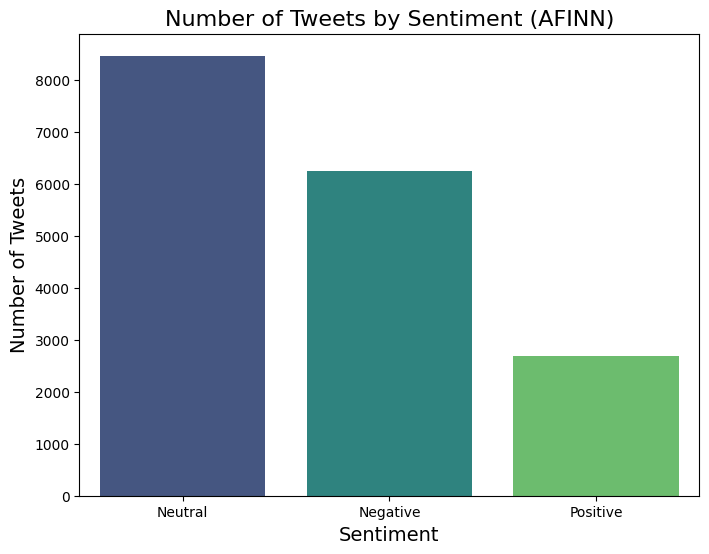

In [50]:
# Classify each tweet as positive, neutral, or negative based on sentiment score
def classify_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply classification to the sentiment scores
isis['sentiment_label'] = isis['sentiment_score'].apply(classify_sentiment)

# Count the number of tweets in each category
sentiment_counts = isis['sentiment_label'].value_counts().reset_index()

# Rename columns for clarity
sentiment_counts.columns = ['Sentiment', 'Count']

# Plot the sentiment distribution
plt.figure(figsize=(8,6))
sns.barplot(x='Sentiment', y='Count', data=sentiment_counts, hue='Sentiment', dodge=False, palette='viridis')
plt.title('Number of Tweets by Sentiment (AFINN)', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Number of Tweets', fontsize=14)
plt.show()

In [51]:
# Sample positive tweet
print("** Sample positive tweet **")
print(isis['tweets'].iloc[10568])
print("Sentiment score:", isis['sentiment_score'].iloc[10568])
print("Sentiment label:", isis['sentiment_label'].iloc[10568])
print ("\n")

# Sample negative tweet
print("** Sample negative tweet **")
print(isis['tweets'].iloc[3605])
print("Sentiment score:", isis['sentiment_score'].iloc[3605])
print("Sentiment label:", isis['sentiment_label'].iloc[3605])
print ("\n")

# Sample neutral tweet
print("** Sample neutral tweet **")
print(isis['tweets'].iloc[3659])
print("Sentiment score:", isis['sentiment_score'].iloc[3659])
print("Sentiment label:", isis['sentiment_label'].iloc[3659])
print ("\n")


** Sample positive tweet **
The Islamic state smarter fighter than the all fighting around the world they r never defeated they are continues to expand it teritry
Sentiment score: 0.0
Sentiment label: Neutral


** Sample negative tweet **
#USA #Pentagon: Countries who can not join the anti #ISIS Coalition militarily should financially contribute to it..
Sentiment score: 0.0
Sentiment label: Neutral


** Sample neutral tweet **
State news in english. Audio.
https://t.co/di39j9yoNu
Wanna hear?? Okay then go there.
Sentiment score: 0.0
Sentiment label: Neutral




### 4.1.3 Predict sentiments using the BERTweet pre-trained model

BERTweet is a transformer-based language model pre-trained on a large corpus of tweets. It leverages deep learning and contextual word embeddings to capture the sentiment of a text. It can classify sentiment based on complex word interactions and context.  

References:  
Nguyen, D. Q., Vu, T., & Nguyen, A. T. (2020). BERTweet: A pre-trained language model for English Tweets. arXiv preprint arXiv:2005.10200.  
https://huggingface.co/docs/transformers/en/model_doc/bertweet  
https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis

In [ ]:
# Load the BERTweet tokenizer and model (for sentiment analysis)
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)
model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")

sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

def predict_sentiment(tweet):
    processed_tweet = ' '.join(tweet)  # Join the preprocessed wordlist back into a single tweet string
    sentiment = sentiment_analyzer(processed_tweet)
    return sentiment[0]['label'], sentiment[0]['score']

# Apply the prediction to the dataset
isis['sentiment_label'], isis['sentiment_score'] = zip(*isis['wordlist'].apply(predict_sentiment))

print(isis[['tweets', 'sentiment_label', 'sentiment_score']].head())

C:\Users\shaof\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


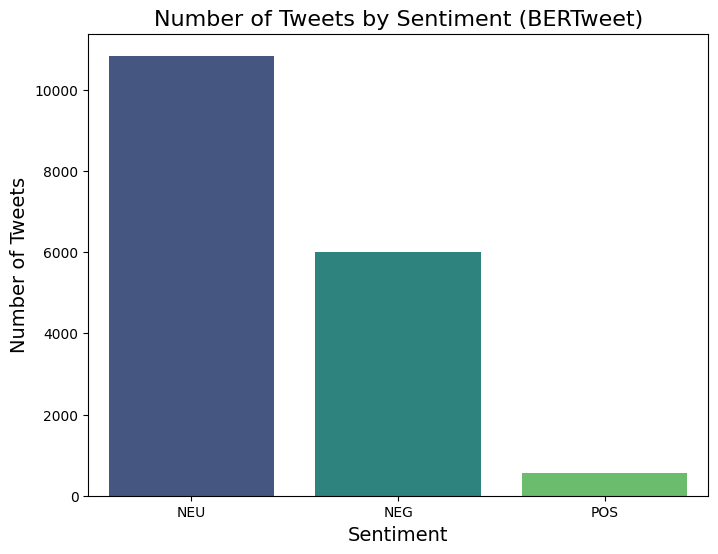

In [ ]:
# Count the number of tweets in each category
sentiment_counts = isis['sentiment_label'].value_counts().reset_index()

# Rename columns for clarity
sentiment_counts.columns = ['Sentiment', 'Count']

# Plot the sentiment distribution
plt.figure(figsize=(8,6))
sns.barplot(x='Sentiment', y='Count', data=sentiment_counts, hue='Sentiment', dodge=False, palette='viridis')
plt.title('Number of Tweets by Sentiment (BERTweet)', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Number of Tweets', fontsize=14)
plt.show()

In [ ]:
# Sample positive tweet
print("** Sample positive tweet **")
print(isis['tweets'].iloc[10568])
print("Sentiment score:", isis['sentiment_score'].iloc[10568])
print("Sentiment label:", isis['sentiment_label'].iloc[10568])
print ("\n")

# Sample negative tweet
print("** Sample negative tweet **")
print(isis['tweets'].iloc[3605])
print("Sentiment score:", isis['sentiment_score'].iloc[3605])
print("Sentiment label:", isis['sentiment_label'].iloc[3605])
print ("\n")

# Sample neutral tweet
print("** Sample neutral tweet **")
print(isis['tweets'].iloc[3659])
print("Sentiment score:", isis['sentiment_score'].iloc[3659])
print("Sentiment label:", isis['sentiment_label'].iloc[3659])
print ("\n")


The Islamic state smarter fighter than the all fighting around the world they r never defeated they are continues to expand it teritry
Sentiment score: 0.0
Sentiment label: Neutral
#USA #Pentagon: Countries who can not join the anti #ISIS Coalition militarily should financially contribute to it..
Sentiment score: 0.0
Sentiment label: Neutral


# 5. Analyse tweets in sentiment categories

## 5.1 Analyse positive tweets

### 5.1.1 Word Cloud

              username                                             tweets
31     YazeedDhardaa25  Salamu Alaykum. I'm back. Do supports and spre...
33     abubakerdimshqi  best generation ever, TAKBIRRR #IS #Dawlah #cu...
94            BaqiyaIs  #WilayatAlFallujah\n\nNew Video : The Knights ...
98            BaqiyaIs  #WilayatAlFurat\nNew Video : Rejoice of the Ci...
172    YazeedDhardaa25  A beautiful scenery can be seen on this pictur...
...                ...                                                ...
17211       melvynlion  RT @AbedaDocrat: Verily,ALLAH &amp; His angels...
17251           ro34th  #Amaq 1300 people take part in Nawawi's 40 Had...
17298           ro34th  RT @benad36: This post is dedicated to the eve...
17323    Uncle_SamCoco  @_Phosphenia Hey ! You have some ebook of Arab...
17366       melvynlion  RT @MADANI_SMS: It’s A New Day\nIt's Friday\n#...

[568 rows x 2 columns]


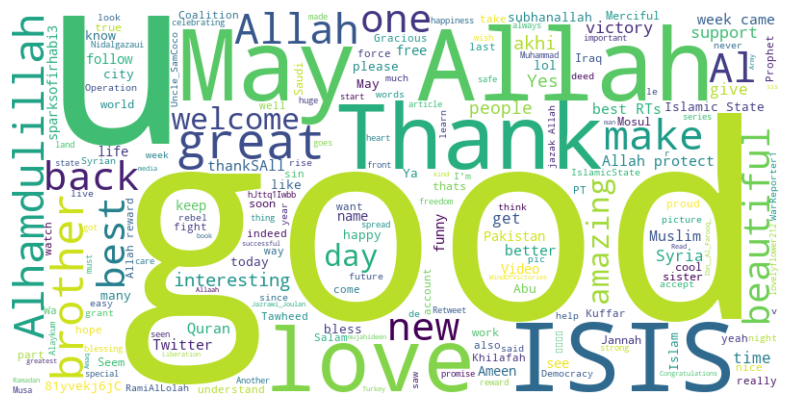

In [46]:
# Filter the dataset to find only positive tweets
#positive_tweets = isis[isis['sentiment_score'] > 0]
positive_tweets = isis[isis['sentiment_label'] == 'POS']

# List the handles and corresponding tweets that are positive
positive_tweet_list = positive_tweets[['username', 'tweets']]

# Display the result
print(positive_tweet_list)

# Combine all positive tweets into a single string
all_positive_tweets = ' '.join(positive_tweet_list['tweets'])

# Create the word cloud object
custom_stopwords = set(stopwords.words('english')).union({'RT', 'http', 'https', 'co', 'amp'})
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=custom_stopwords).generate(all_positive_tweets)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 5.1.2 Most common words

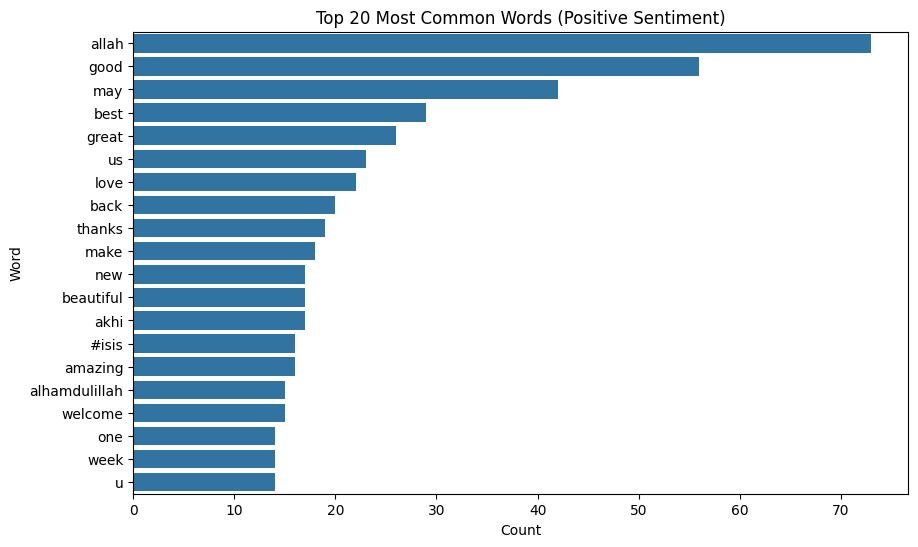

In [44]:
# Get the most common words
custom_stopwords = set(stopwords.words('english')).union({'RT', 'rt', 'http', 'https', 'co', '&amp;'})

word_counts = Counter([word.lower() for tweet in positive_tweets.tweets 
                       for word in tweet.split() if word.lower() not in custom_stopwords])
common_words = word_counts.most_common(20) # Top 20 most common words

# Convert to DataFrame for easy visualization
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Count'])

# Plot the top 20 most common words
plt.figure(figsize=(10,6))
sns.barplot(x='Count', y='Word', data=common_words_df)
plt.title('Top 20 Most Common Words (Positive Sentiment)')
plt.show()


### 5.1.3 Most common hashtags

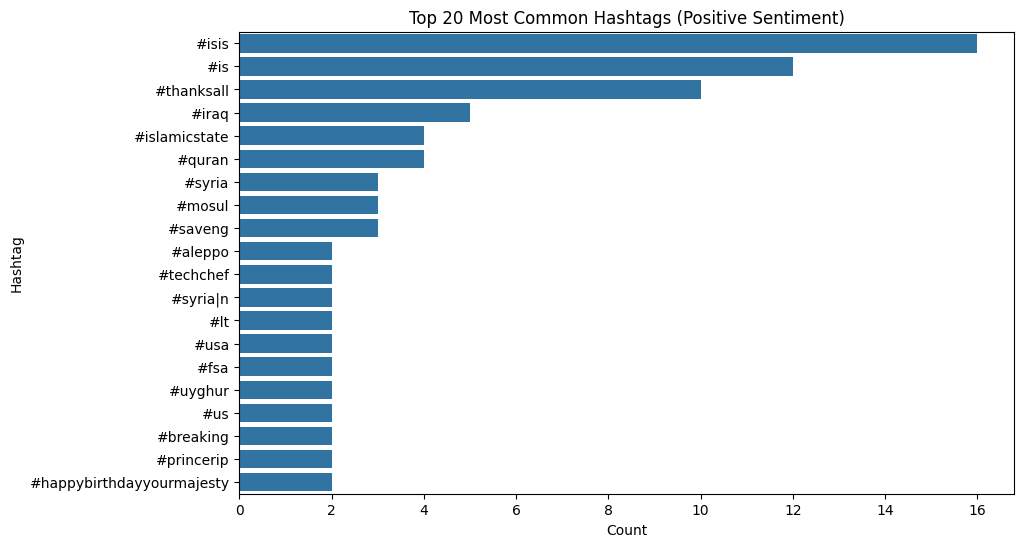

In [47]:
# Extract hashtags from the tweets
hashtags = [word.lower() for tweet in positive_tweets.tweets for word in tweet.split() if word.startswith('#')]

# Get the most common hashtags
hashtag_counts = Counter(hashtags)
common_hashtags = hashtag_counts.most_common(20)

# Convert to DataFrame for visualization
common_hashtags_df = pd.DataFrame(common_hashtags, columns=['Hashtag', 'Count'])

# Plot the top 20 hashtags
plt.figure(figsize=(10,6))
sns.barplot(x='Count', y='Hashtag', data=common_hashtags_df)
plt.title('Top 20 Most Common Hashtags (Positive Sentiment)')
plt.show()

## 5.2 Analyse negative tweets

### 5.2.1 Word Cloud

              username                                             tweets
42     YazeedDhardaa25  @Skxx51 truth behind Jan13 where he's asserted...
48            BaqiyaIs  @abuyaqub6: RT @Alwalawalbara12: May Allah pun...
70            BaqiyaIs  Iraq\nHashd criminals bought to justice same w...
73            BaqiyaIs  Yarmouk TV channel linked to the Jordanian Mus...
74            BaqiyaIs  @anti__terrorist: #WilayatAlJazirah\nHarvestin...
...                ...                                                ...
17399    Uncle_SamCoco  RT @SimNasr: Erratum shiaa Afghan fighters who...
17401   Mountainjjoool  Heavy battles going on in Al Karmah northeast ...
17403          nvor85j  9 Hummers an autocannon and a field artillery ...
17406          nvor85j  #Breaking\n\n Iraqi forces bulldozer destroyed...
17409           ro34th  #AmaqAgency Destroyed and burning Iraqi Forces...

[6005 rows x 2 columns]


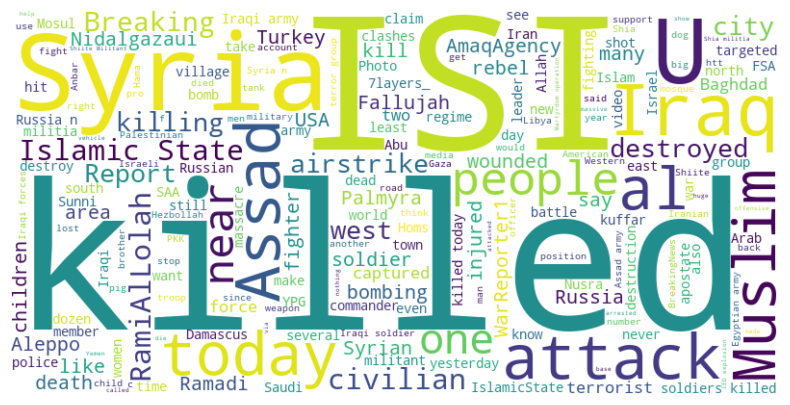

In [49]:
# Filter the dataset to find only negative tweets
#negative_tweets = isis[isis['sentiment_score'] < 0]
negative_tweets = isis[isis['sentiment_label'] == 'NEG']

# List the handles and corresponding tweets that are negative
negative_tweet_list = negative_tweets[['username', 'tweets']]

# Display the result
print(negative_tweet_list)

# Combine all negative tweets into a single string
all_negative_tweets = ' '.join(negative_tweet_list['tweets'])

# Create the word cloud object
custom_stopwords = set(stopwords.words('english')).union({'RT', 'rt', 'http', 'https', 'co', 'amp'})
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=custom_stopwords).generate(all_negative_tweets)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 5.2.2 Most common words

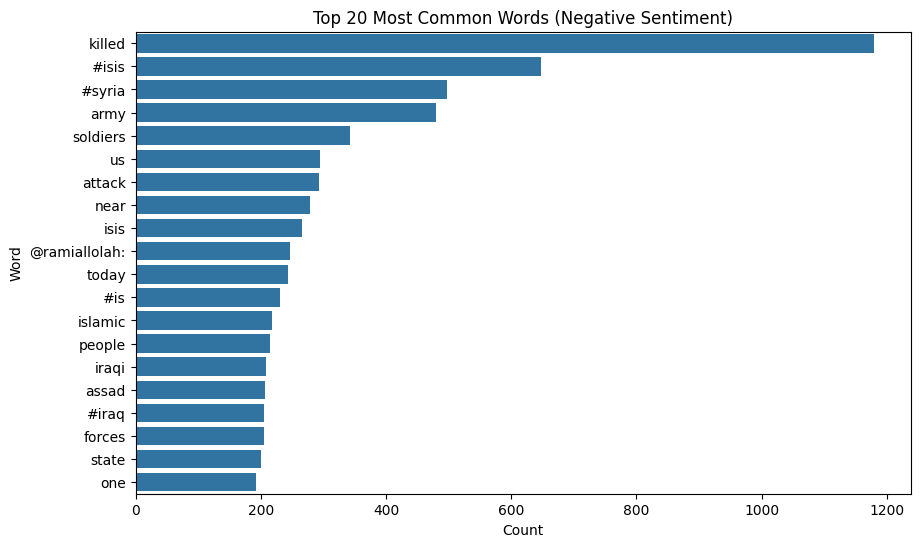

In [51]:
# Get the most common words
custom_stopwords = set(stopwords.words('english')).union({'RT', 'rt', 'http', 'https', 'co', '&amp;'})

word_counts = Counter([word.lower() for tweet in negative_tweets.tweets 
                       for word in tweet.split() if word.lower() not in custom_stopwords])
common_words = word_counts.most_common(20) # Top 20 most common words

# Convert to DataFrame for easy visualization
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Count'])

# Plot the top 20 most common words
plt.figure(figsize=(10,6))
sns.barplot(x='Count', y='Word', data=common_words_df)
plt.title('Top 20 Most Common Words (Negative Sentiment)')
plt.show()


### 5.2.3 Most common hashtags

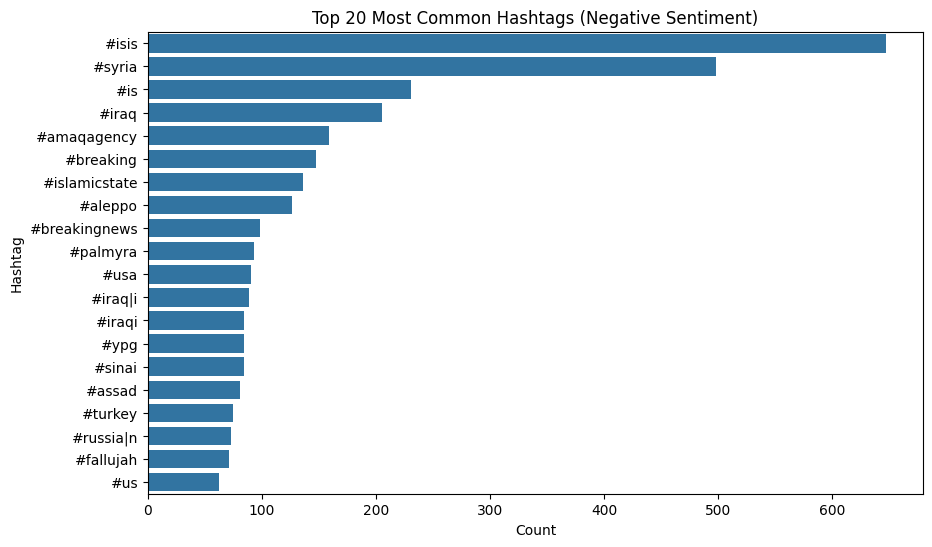

In [52]:
# Extract hashtags from the tweets
hashtags = [word.lower() for tweet in negative_tweets.tweets for word in tweet.split() if word.startswith('#')]

# Get the most common hashtags
hashtag_counts = Counter(hashtags)
common_hashtags = hashtag_counts.most_common(20)

# Convert to DataFrame for visualization
common_hashtags_df = pd.DataFrame(common_hashtags, columns=['Hashtag', 'Count'])

# Plot the top 20 hashtags
plt.figure(figsize=(10,6))
sns.barplot(x='Count', y='Hashtag', data=common_hashtags_df)
plt.title('Top 20 Most Common Hashtags (Negative Sentiment)')
plt.show()

## 5.3 Analyse neutral tweets

### 5.3.1 Word Cloud

              username                                             tweets
0      GunsandCoffee70  ENGLISH TRANSLATION: 'A MESSAGE TO THE TRUTHFU...
1      GunsandCoffee70  ENGLISH TRANSLATION: SHEIKH FATIH AL JAWLANI '...
2      GunsandCoffee70  ENGLISH TRANSLATION: FIRST AUDIO MEETING WITH ...
3      GunsandCoffee70  ENGLISH TRANSLATION: SHEIKH NASIR AL WUHAYSHI ...
4      GunsandCoffee70  ENGLISH TRANSLATION: AQAP: 'RESPONSE TO SHEIKH...
...                ...                                                ...
17402    Uncle_SamCoco  "Is the Islamic State trying  to draw Turkey i...
17404    Uncle_SamCoco  #LT Notice that this possible strategy was men...
17405          nvor85j  #Breaking\n#IslamicState \n#AmaqAgency \n\n#Fr...
17407          nvor85j  #Breaking \n#AmaqAgency \n#IslamicState \n\n#E...
17408          nvor85j  #PhotoReport \n#WilayatDimasiqh \n\n📷The Condu...

[10837 rows x 2 columns]


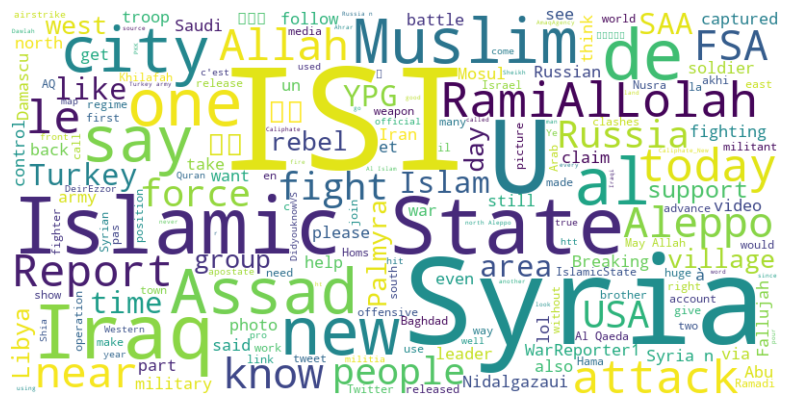

In [54]:
# Filter the dataset to find only neutral tweets
#neutral_tweets = isis[isis['sentiment_score'] == 0]
neutral_tweets = isis[isis['sentiment_label'] == 'NEU']

# List the handles and corresponding tweets that are neutral
neutral_tweet_list = neutral_tweets[['username', 'tweets']]

# Display the result
print(neutral_tweet_list)

# Combine all neutral tweets into a single string
all_neutral_tweets = ' '.join(neutral_tweet_list['tweets'])

# Create the word cloud object
custom_stopwords = set(stopwords.words('english')).union({'RT', 'http', 'https', 'co', 'amp'})
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=custom_stopwords).generate(all_neutral_tweets)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 5.3.2 Most common words

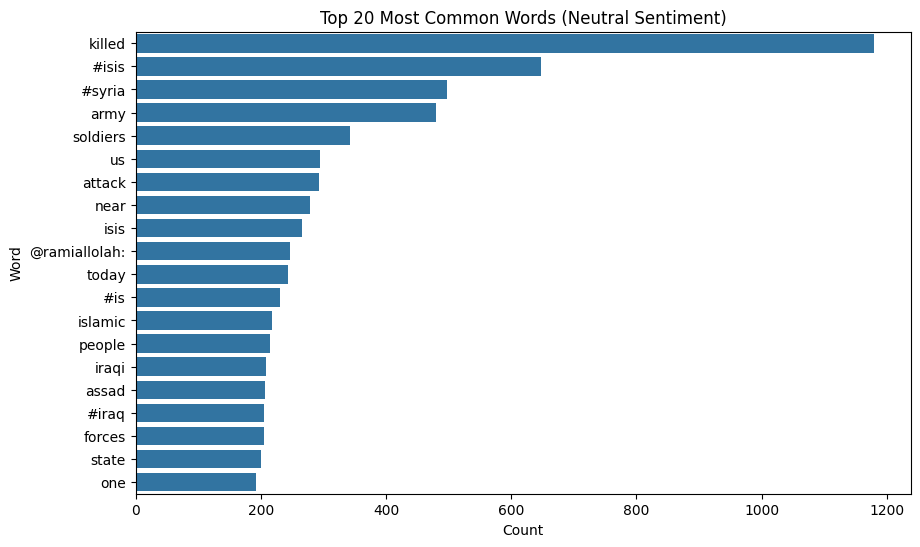

In [55]:
# Get the most common words
custom_stopwords = set(stopwords.words('english')).union({'RT', 'rt', 'http', 'https', 'co', '&amp;'})

word_counts = Counter([word.lower() for tweet in negative_tweets.tweets 
                       for word in tweet.split() if word.lower() not in custom_stopwords])
common_words = word_counts.most_common(20) # Top 20 most common words

# Convert to DataFrame for easy visualization
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Count'])

# Plot the top 20 most common words
plt.figure(figsize=(10,6))
sns.barplot(x='Count', y='Word', data=common_words_df)
plt.title('Top 20 Most Common Words (Neutral Sentiment)')
plt.show()


### 5.3.3 Most common hashtags

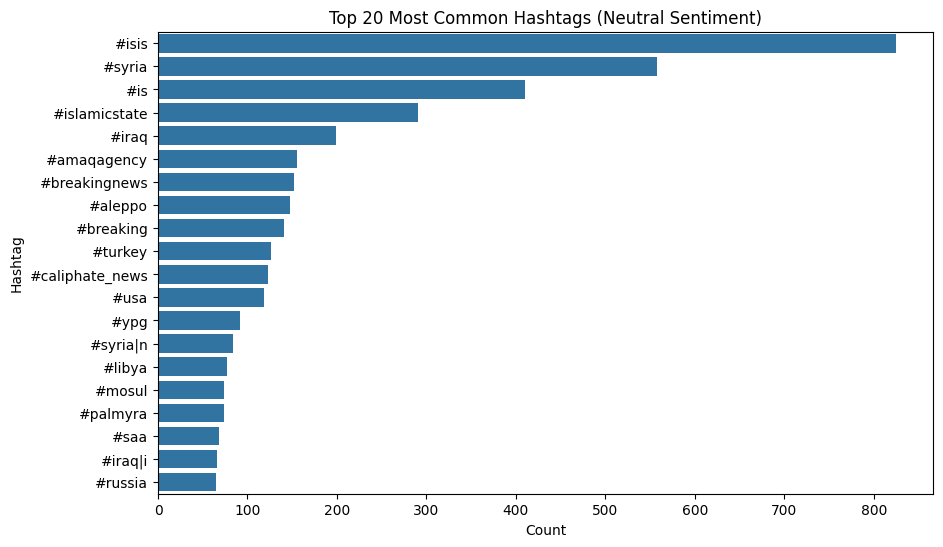

In [56]:
# Extract hashtags from the tweets
hashtags = [word.lower() for tweet in neutral_tweets.tweets for word in tweet.split() if word.startswith('#')]

# Get the most common hashtags
hashtag_counts = Counter(hashtags)
common_hashtags = hashtag_counts.most_common(20)

# Convert to DataFrame for visualization
common_hashtags_df = pd.DataFrame(common_hashtags, columns=['Hashtag', 'Count'])

# Plot the top 20 hashtags
plt.figure(figsize=(10,6))
sns.barplot(x='Count', y='Hashtag', data=common_hashtags_df)
plt.title('Top 20 Most Common Hashtags (Neutral Sentiment)')
plt.show()